In [1]:
%pip install -q numpy pandas matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [25]:
import json
import os
import re
import glob
from collections import defaultdict
from typing import List, Tuple, Optional

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ==========================================================
# Funções reutilizáveis: passe o diretório da aplicação
#
# Convenção nova (preferencial):
#   app_dir/
#     out/total.out                  (tempos reais)
#     total.json                     (argumentos/entradas)
#     10.json, 20.json, 37.json...   (estimativas por %)
#
# Compatibilidade com a convenção antiga (multi-paramount):
#   app_dir/mult-pascal-sscad-teste2.json           (total)
#   app_dir/mult-paramount10-sscad.json, ...        (parciais)
#   app_dir/out/total.out OU raytrace/slurm/total.out
# ==========================================================

def extract_first_number(text: str) -> int:
    m = re.search(r"\d+", str(text))
    return int(m.group(0)) if m else 0


def first_existing(paths):
    for p in paths:
        if p and os.path.exists(p):
            return p
    tried = "\n".join(f" - {p}" for p in paths if p)
    raise FileNotFoundError(f"Nenhum arquivo encontrado. Tentei:\n{tried}")


def parse_total_out(total_out_path: str):
    """
    Parseia o total.out no formato:
      "Cores: 128 Input: 0"
      "Total time 0.027245283126831055"
    Retorna:
      cores_list (desc) e real_times_map[input_idx] = [t_core128, t_core64, ...]
    onde cada tempo é a média das repetições no log.
    """
    with open(total_out_path, "r") as f:
        lines = f.readlines()

    data = defaultdict(list)  # (cores, input) -> [t1, t2, ...]
    current = None

    re_header = re.compile(r"Cores:\s*(\d+)\s+Input:\s*(\d+)")
    re_time = re.compile(r"Total time\s*([0-9\.]+)")

    for line in lines:
        m = re_header.search(line)
        if m:
            cores = int(m.group(1))
            inp = int(m.group(2))
            current = (cores, inp)
            continue

        m2 = re_time.search(line)
        if m2 and current is not None:
            data[current].append(float(m2.group(1)))

    if not data:
        raise ValueError(
            f"Parse vazio em {total_out_path}. Verifique se o arquivo contém linhas 'Cores:' e 'Total time'."
        )

    means = {}  # (cores, input) -> mean_time
    for key, times in data.items():
        means[key] = float(sum(times) / len(times))

    grouped_by_input = defaultdict(dict)  # input -> {cores: mean_time}
    cores_set = set()
    for (cores, inp), mean_time in means.items():
        grouped_by_input[inp][cores] = mean_time
        cores_set.add(cores)

    cores_list = sorted(cores_set, reverse=True)
    real_times_map = {}
    for inp in sorted(grouped_by_input.keys()):
        times_by_core = grouped_by_input[inp]
        real_times_map[inp] = [times_by_core.get(c, np.nan) for c in cores_list]

    return cores_list, real_times_map


def extract_times_by_input(data: dict, input_idx: int):
    """
    Retorna dict {cores: tempo_estimado_em_segundos} para um input_idx, usando:
      tempo = max(stop_time das regiões) - start_time
    """
    times = {}
    pattern = re.compile(rf"^(\d+);{input_idx};1$")

    for key, entry in data.get("data", {}).items():
        m = pattern.match(key)
        if not m:
            continue

        ncores = int(m.group(1))
        start = entry.get("start_time")
        regions_dict = entry.get("regions", {})
        if start is None or not regions_dict:
            times[ncores] = np.nan
            continue

        try:
            max_stop = max(
                stop
                for regions in regions_dict.values()
                for (_, stop, *_) in regions
            )
            times[ncores] = float(max_stop - start)
        except Exception:
            times[ncores] = np.nan

    return times


def _percent_label_from_path(path: str) -> str:
    base = os.path.basename(path)
    stem, _ext = os.path.splitext(base)
    # novo padrão: 10.json -> 10%
    if stem.isdigit():
        return f"{int(stem)}%"
    # antigo padrão: mult-paramount10-sscad.json -> 10%
    m = re.search(r"mult-paramount(\d+)", base)
    if m:
        return f"{m.group(1)}%"
    # fallback
    return stem


def _percent_value(label: str) -> int:
    return extract_first_number(label)


def _find_total_json(app_dir: str) -> str:
    candidates = [
        os.path.join(app_dir, "total.json"),
        os.path.join(app_dir, "mult-pascal-sscad-teste2.json"),
    ]
    for c in candidates:
        if os.path.exists(c):
            return c
    # fallback: qualquer json com 'total' no nome
    for p in sorted(glob.glob(os.path.join(app_dir, "*total*.json"))):
        return p
    raise FileNotFoundError(
        f"Não encontrei o JSON total em {app_dir}. Esperado: total.json (novo) ou mult-pascal-sscad-teste2.json (antigo)."
    )


def _find_partial_jsons(app_dir: str, total_json_path: str) -> List[Tuple[str, str]]:
    """Retorna lista de tuplas (path, label)."""
    # novo: 10.json, 20.json, ...
    all_json = [p for p in glob.glob(os.path.join(app_dir, "*.json"))]
    all_json = [p for p in all_json if os.path.abspath(p) != os.path.abspath(total_json_path)]
    numeric = [p for p in all_json if os.path.splitext(os.path.basename(p))[0].isdigit()]
    if numeric:
        numeric = sorted(numeric, key=lambda p: extract_first_number(os.path.basename(p)))
        return [(p, _percent_label_from_path(p)) for p in numeric]

    # antigo: mult-paramount*-sscad.json
    old = glob.glob(os.path.join(app_dir, "mult-paramount*-sscad.json"))
    old = sorted(old, key=lambda p: extract_first_number(os.path.basename(p)))
    if old:
        return [(p, _percent_label_from_path(p)) for p in old]

    raise FileNotFoundError(
        f"Não encontrei JSONs parciais em {app_dir}. Esperado novo (10.json/20.json/...) ou antigo (mult-paramount*-sscad.json)."
    )


def _find_total_out(app_dir: str) -> str:
    candidates = [
        os.path.join(app_dir, "out", "total.out"),
        os.path.join(app_dir, "out", "total"),  # caso sem extensão
        os.path.join("raytrace", "slurm", "total.out"),  # legado do seu workspace
    ]
    try:
        return first_existing(candidates)
    except FileNotFoundError:
        # fallback: primeiro arquivo com 'total' dentro de app_dir/out
        out_dir = os.path.join(app_dir, "out")
        if os.path.isdir(out_dir):
            for p in sorted(glob.glob(os.path.join(out_dir, "*total*"))):
                return p
        raise


def build_error_dataset(app_dir: str):
    """
    Constrói df_errors (formato longo) e devolve também cores_list (desc).
    Colunas df_errors: Paramount, Núcleos, Entrada, Erro Relativo (%) (ASSINADO)

    Convenção do sinal:
      err = ((estimado - real) / real) * 100
      err > 0  => pessimista (superestima o tempo)
      err < 0  => otimista  (subestima o tempo)
    """
    app_dir = os.path.abspath(app_dir)
    total_out_path = _find_total_out(app_dir)
    total_json_path = _find_total_json(app_dir)
    partials = _find_partial_jsons(app_dir, total_json_path)

    cores_list, real_times_map = parse_total_out(total_out_path)

    with open(total_json_path, "r") as f:
        total_data = json.load(f)

    arguments = total_data.get("config", {}).get("arguments", [])
    arg_labels = [os.path.basename(arg) for arg in arguments]
    sorted_arg_labels = sorted(arg_labels, key=extract_first_number)
    arg_label_to_idx = {label: i for i, label in enumerate(arg_labels)}

    error_rows = []
    for json_path, percentage_label in partials:
        with open(json_path, "r") as f:
            partial_data = json.load(f)

        for arg_label in sorted_arg_labels:
            input_idx = arg_label_to_idx.get(arg_label)
            if input_idx is None:
                continue

            real_times = real_times_map.get(input_idx)
            if real_times is None:
                continue

            est_by_core = extract_times_by_input(partial_data, input_idx)
            est_times = [est_by_core.get(c, np.nan) for c in cores_list]

            for ncores, r, e in zip(cores_list, real_times, est_times):
                if pd.isna(r) or r <= 0 or pd.isna(e):
                    err = np.nan
                else:
                    # erro relativo: preserva otimismo/pessimismo
                    err = ((e - r) / r) * 100.0

                error_rows.append(
                    {
                        "Paramount": percentage_label,
                        "Núcleos": int(ncores),
                        "Entrada": extract_first_number(arg_label),
                        "Erro Relativo (%)": err,
                    }
                )

    df_errors = pd.DataFrame(error_rows)
    if df_errors.empty:
        raise ValueError(
            "df_errors ficou vazio: não foi possível casar total.out com os JSONs parciais/total."
        )

    paramount_order = sorted(df_errors["Paramount"].dropna().unique(), key=_percent_value)
    df_errors["Paramount"] = pd.Categorical(df_errors["Paramount"], categories=paramount_order, ordered=True)
    df_errors["Entrada"] = pd.to_numeric(df_errors["Entrada"], errors="coerce")

    print(f"APP: {app_dir}")
    print(f"total.out: {total_out_path}")
    print(f"total.json: {total_json_path}")
    print(f"parciais: {[os.path.basename(p) for p,_ in partials]}")
    print(f"df_errors: {len(df_errors)} linhas | {df_errors['Paramount'].nunique()} porcentagens")

    return df_errors, cores_list


def plot_error_heatmaps(df_errors: pd.DataFrame, vmax: float = 100.0):
    for pct in df_errors["Paramount"].cat.categories:
        sub = df_errors[df_errors["Paramount"] == pct]
        heatmap_df = (
            sub.pivot(index="Núcleos", columns="Entrada", values="Erro Relativo (%)")
            .sort_index(ascending=False)
        )
        if heatmap_df.empty:
            continue

        annot = heatmap_df.applymap(lambda x: "" if pd.isna(x) else f"{x:.2f}%")
        plt.figure(figsize=(12, 8))
        sns.heatmap(
            heatmap_df,
            annot=annot,
            fmt="",
            cmap="coolwarm",
            cbar_kws={"label": "Erro Relativo (%) = (estimado-real)/real"},
            vmin=-vmax,
            vmax=vmax,
            center=0,
            annot_kws={"size": 12},
            mask=heatmap_df.isna(),
        )
        plt.title(f"Paramount: {pct} (+: pessimista | -: otimista)")
        plt.xlabel("Tamanho da Entrada (Problema)")
        plt.ylabel("Número de Cores")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()


def plot_error_lines_by_input(df_errors: pd.DataFrame, limiar: float = 5.0, save_path: Optional[str] = None):
    sns.set_theme(style="whitegrid")
    plt.rcParams.update({"font.family": "sans-serif", "font.size": 11})

    df = df_errors.copy()
    df = df.dropna(subset=["Erro Relativo (%)", "Entrada", "Núcleos"])
    inputs = sorted(df["Entrada"].unique())

    g = sns.relplot(
        data=df,
        x="Núcleos",
        y="Erro Relativo (%)",
        hue="Paramount",
        col="Entrada",
        col_order=inputs,
        col_wrap=len(inputs),
        kind="line",
        style="Paramount",
        markers=True,
        dashes=False,
        height=4,
        aspect=1,
        palette="viridis_r",
        linewidth=2,
        facet_kws={"sharex": True, "sharey": True},
    )

    # x em log; y precisa aceitar valores negativos (erro assinado)
    g.set(xscale="log")

    ticks_nucleos = [1, 2, 4, 8, 16, 32, 64, 128]
    from matplotlib.ticker import FuncFormatter

    def _symlog_tick_fmt(value, _pos):
        if np.isclose(value, 0.0):
            return "0"
        # remove ±10^0 (i.e., ticks em ±1)
        if np.isclose(abs(value), 1.0):
            return ""
        sign = "-" if value < 0 else ""
        abs_v = abs(value)
        if abs_v > 0:
            exp = np.log10(abs_v)
            if np.isclose(exp, round(exp), atol=1e-10):
                return f"{sign}$10^{int(round(exp))}$"
        return f"{value:g}"

    for ax in g.axes.flatten():
        ax.set_yscale("symlog", linthresh=limiar)
        ax.yaxis.set_major_formatter(FuncFormatter(_symlog_tick_fmt))
        ax.set_xticks(ticks_nucleos)
        ax.set_xticklabels(ticks_nucleos)
        ax.grid(True, which="minor", axis="x", linestyle=":", alpha=0.4)
        # faixa de limiar: intervalo aceitável [-limiar, +limiar]
        ax.axhspan(-limiar, limiar, color="red", alpha=0.10, zorder=0)
        # linha do zero (mais destacada)
        ax.axhline(y=0, color="black", linestyle="-", linewidth=1.6, alpha=0.65, zorder=1)
        ax.axhline(y=limiar, color="red", linestyle="--", linewidth=1.2, alpha=0.8)
        ax.axhline(y=-limiar, color="red", linestyle="--", linewidth=1.2, alpha=0.8)

    g.fig.subplots_adjust(top=0.88)
    g.set_axis_labels("Quantidade de Cores", "Erro Relativo (%)")
    g.fig.suptitle("Erro Relativo por Entrada (+: pessimista | -: otimista)")

    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()

def plot_error_lines_by_paramount(
    df_errors: pd.DataFrame,
    limiar: float = 5.0,
    save_path: Optional[str] = None
):
    sns.set_theme(style="whitegrid")
    plt.rcParams.update({"font.family": "sans-serif", "font.size": 11})

    df = df_errors.copy()
    df = df.dropna(subset=["Erro Relativo (%)", "Entrada", "Núcleos"])

    entradas = sorted(df["Entrada"].unique())

    g = sns.relplot(
        data=df,
        x="Núcleos",
        y="Erro Relativo (%)",
        hue="Entrada",          # cor por entrada
        style="Entrada",        # marcador por entrada  ← 🔑
        markers=True,           # ativa marcadores diferentes
        dashes=False,           # evita confusão visual
        col="Paramount",        # subgráficos = porcentagens
        col_order=df["Paramount"].cat.categories,
        kind="line",
        height=4,
        aspect=1,
        linewidth=2,
        palette="viridis",
        facet_kws={"sharex": True, "sharey": True},
    )

    # x em log; y precisa aceitar valores negativos (erro assinado)
    g.set(xscale="log")

    ticks_nucleos = [1, 2, 4, 8, 16, 32, 64, 128]
    from matplotlib.ticker import FuncFormatter

    def _symlog_tick_fmt(value, _pos):
        if np.isclose(value, 0.0):
            return "0"
        if np.isclose(abs(value), 1.0):
            return ""
        sign = "-" if value < 0 else ""
        abs_v = abs(value)
        if abs_v > 0:
            exp = np.log10(abs_v)
            if np.isclose(exp, round(exp), atol=1e-10):
                return f"{sign}$10^{int(round(exp))}$"
        return f"{value:g}"

    for ax in g.axes.flatten():
        ax.set_yscale("symlog", linthresh=limiar)
        ax.yaxis.set_major_formatter(FuncFormatter(_symlog_tick_fmt))
        ax.set_xticks(ticks_nucleos)
        ax.set_xticklabels(ticks_nucleos)
        ax.grid(True, which="minor", axis="x", linestyle=":", alpha=0.4)
        ax.axhspan(-limiar, limiar, color="red", alpha=0.10, zorder=0)
        ax.axhline(y=0, color="black", linestyle="-", linewidth=1.6, alpha=0.65, zorder=1)
        ax.axhline(y=limiar, color="red", linestyle="--", linewidth=1.1, alpha=0.8)
        ax.axhline(y=-limiar, color="red", linestyle="--", linewidth=1.1, alpha=0.8)

    g.set_axis_labels("Quantidade de Cores", "Erro Relativo (%)")
    g.fig.subplots_adjust(top=0.85)
    g.fig.suptitle("Erro Relativo (+: pessimista | -: otimista)")

    g._legend.set_title("Entrada")

    if save_path:
        plt.savefig(save_path, bbox_inches="tight")

    plt.show()


def plot_error_lines_by_paramount_thesis(
    df_errors,
    limiar: float = 5.0,
    save_path: Optional[str] = None,
    dpi: int = 300
):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd

    sns.set_theme(style="whitegrid", context="paper")
    plt.rcParams.update({
        "font.family": "serif",
        "font.size": 12,
        "axes.titlesize": 11,
        "axes.labelsize": 12,
        "legend.fontsize": 10,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "savefig.dpi": dpi,
    })

    df = df_errors.copy()
    df = df.dropna(subset=["Erro Relativo (%)", "Entrada", "Núcleos", "Paramount"])

    entradas = sorted(df["Entrada"].unique())

    # marcadores por Entrada (independente de cor)
    base_markers = ["o", "s", "^", "D", "X", "P", "v", "*", "<", ">", "h", "8"]
    markers_map = {e: base_markers[i % len(base_markers)] for i, e in enumerate(entradas)}

    # cores distintas por Entrada (boa para acessibilidade)
    palette = sns.color_palette("colorblind", n_colors=len(entradas))
    palette_map = {e: palette[i] for i, e in enumerate(entradas)}

    g = sns.relplot(
        data=df,
        x="Núcleos",
        y="Erro Relativo (%)",
        col="Paramount",
        col_order=df["Paramount"].cat.categories,
        col_wrap=2,                 # ✅ 2x2 em vez de 1x4 (melhora MUITO)
        hue="Entrada",
        style="Entrada",
        markers=markers_map,
        palette=palette_map,
        dashes=False,
        kind="line",
        linewidth=2.0,
        height=3.6,                 # ✅ mais alto
        aspect=1.35,                # ✅ mais largo sem ficar “fino”
        facet_kws={"sharex": True, "sharey": True},
        legend=True
    )

    # x em log; y precisa aceitar valores negativos (erro assinado)
    g.set(xscale="log")
    ticks_nucleos = [1, 2, 4, 8, 16, 32, 64, 128]

    from matplotlib.ticker import FuncFormatter

    def _symlog_tick_fmt(value, _pos):
        if np.isclose(value, 0.0):
            return "0"
        if np.isclose(abs(value), 1.0):
            return ""
        sign = "-" if value < 0 else ""
        abs_v = abs(value)
        if abs_v > 0:
            exp = np.log10(abs_v)
            if np.isclose(exp, round(exp), atol=1e-10):
                return f"{sign}$10^{int(round(exp))}$"
        return f"{value:g}"

    for ax in g.axes.flatten():
        ax.set_yscale("symlog", linthresh=limiar)
        ax.yaxis.set_major_formatter(FuncFormatter(_symlog_tick_fmt))
        ax.set_xticks(ticks_nucleos)
        ax.set_xticklabels([str(t) for t in ticks_nucleos])

        ax.grid(True, which="major", axis="both", linestyle="-", alpha=0.30)
        ax.grid(True, which="minor", axis="x", linestyle=":", alpha=0.25)

        # faixa do limiar: intervalo aceitável [-limiar, +limiar]
        ax.axhspan(-limiar, limiar, color="red", alpha=0.10, zorder=0)
        ax.axhline(y=0, color="black", linestyle="-", linewidth=1.6, alpha=0.65, zorder=1)
        ax.axhline(y=limiar, color="red", linestyle="--", linewidth=1.1, alpha=0.9)
        ax.axhline(y=-limiar, color="red", linestyle="--", linewidth=1.1, alpha=0.9)

        # texto da faixa de limiar
        ax.annotate(
            f"Limiar: ±{limiar:.0f}%",
            xy=(0.02, limiar),
            xycoords=("axes fraction", "data"),
            xytext=(0, 4),
            textcoords="offset points",
            color="red",
            ha="left",
            va="bottom",
            fontsize=10
        )

    g.set_axis_labels("", "Erro Relativo (%)")
    # g.fig.suptitle("Erro Relativo por Entrada (+: pessimista | -: otimista)", y=0.98)

    # ✅ Reserva espaço e afasta legenda do último subplot
    g.fig.subplots_adjust(top=0.88, right=0.82, wspace=0.18, hspace=0.28)

    # ✅ legenda fora, centralizada verticalmente
    if g._legend is not None:
        g._legend.set_title("Entrada")
        g._legend.set_bbox_to_anchor((0.86, 0.5))  # dentro da área reservada (right=0.82)
        g._legend._loc = 6  # center left

    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=dpi)

    plt.show()



def generate_graphs(app_dir: str, limiar: float = 5.0, vmax: float = 100.0, save_prefix: Optional[str] = None) -> pd.DataFrame:
    df_errors, _cores = build_error_dataset(app_dir)
    # plot_error_heatmaps(df_errors, vmax=vmax)
    # plot_error_lines_by_input(
    #     df_errors,
    #     limiar=limiar,
    #     save_path=(f"{save_prefix}_grafico_por_entrada.png" if save_prefix else None),
    # )
    # plot_error_lines_by_paramount(
    #     df_errors,
    #     limiar=limiar,
    #     save_path=(f"{save_prefix}_grafico_por_paramount.png" if save_prefix else None),
    # )
    plot_error_lines_by_paramount_thesis(
        df_errors,
        limiar=limiar,
        save_path=(f"{save_prefix}_erro_por_paramount.pdf" if save_prefix else None),
        dpi=300,
    )
    return df_errors

APP: /home/reilta/Documents/mestrado/multi-paramount-sscad
total.out: /home/reilta/Documents/mestrado/multi-paramount-sscad/out/total.out
total.json: /home/reilta/Documents/mestrado/multi-paramount-sscad/total.json
parciais: ['10.json', '20.json', '37.json', '50.json']
df_errors: 160 linhas | 4 porcentagens


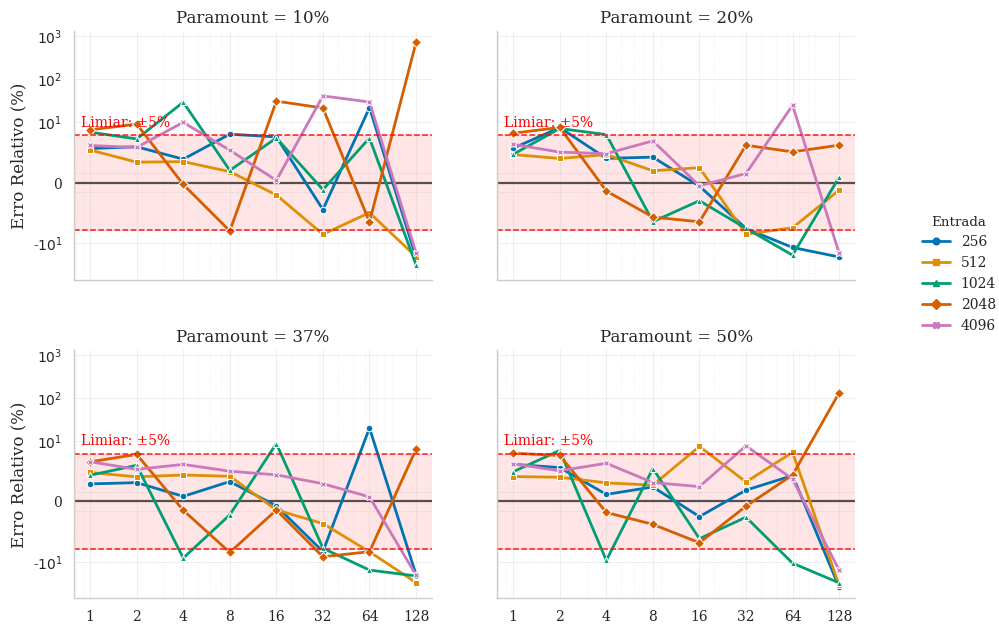

In [26]:
# Célula de execução: troque apenas o diretório da aplicação

# Exemplo 1 (seus dados atuais):
app_dir = os.path.join(os.getcwd(), "multi-paramount-sscad")

# Exemplo 2 (quando cada aplicação estiver em uma pasta própria):
# app_dir = "/caminho/para/minha-aplicacao"

df_errors = generate_graphs(app_dir, limiar=5.0, vmax=100.0, save_prefix=None)

APP: /home/reilta/Documents/mestrado/ep-proxy-afinidade
total.out: /home/reilta/Documents/mestrado/ep-proxy-afinidade/out/total.out
total.json: /home/reilta/Documents/mestrado/ep-proxy-afinidade/total.json
parciais: ['10.json', '20.json', '37.json', '50.json']
df_errors: 128 linhas | 4 porcentagens


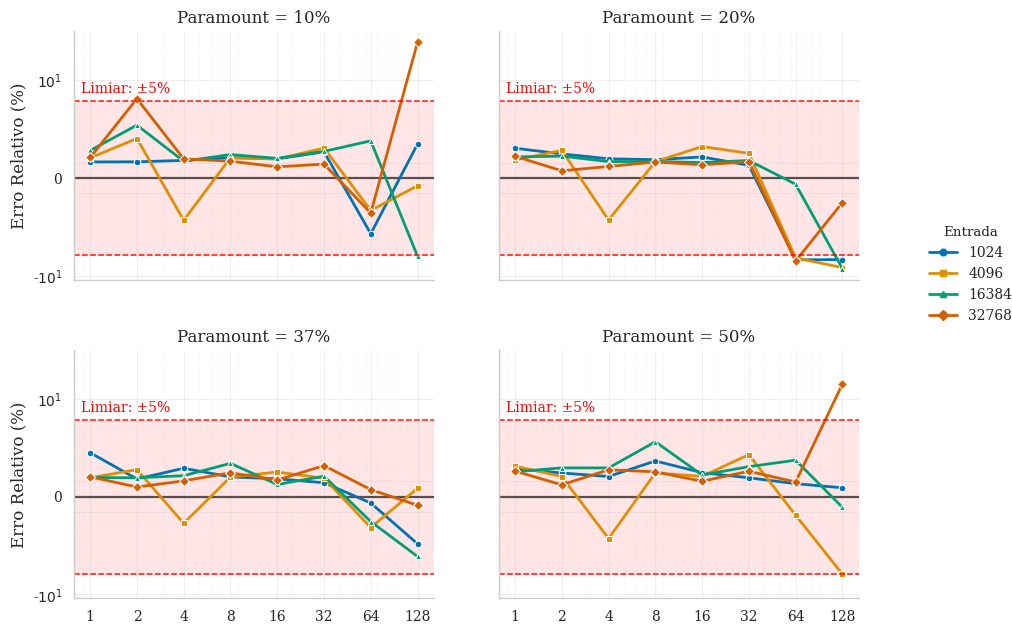

In [27]:
# Célula de execução: troque apenas o diretório da aplicação

# Exemplo 1 (seus dados atuais):
app_dir = os.path.join(os.getcwd(), "ep-proxy-afinidade")

# Exemplo 2 (quando cada aplicação estiver em uma pasta própria):
# app_dir = "/caminho/para/minha-aplicacao"

df_errors = generate_graphs(app_dir, limiar=5.0, vmax=100.0, save_prefix=None)

APP: /home/reilta/Documents/mestrado/ep-proxy
total.out: /home/reilta/Documents/mestrado/ep-proxy/out/total.out
total.json: /home/reilta/Documents/mestrado/ep-proxy/total.json
parciais: ['10.json', '20.json', '37.json', '50.json']
df_errors: 128 linhas | 4 porcentagens


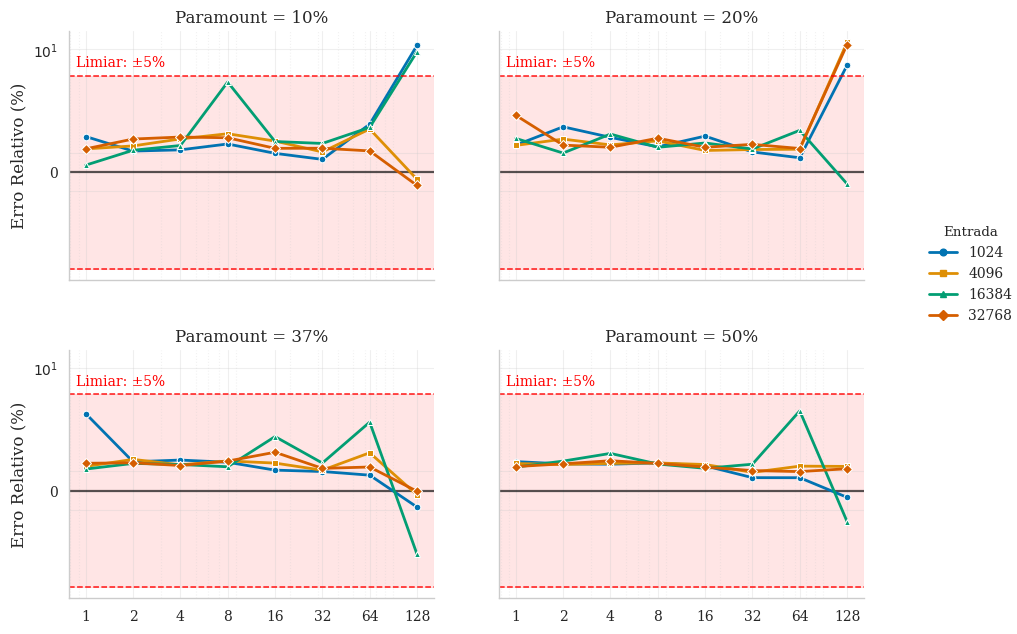

In [28]:
# Célula de execução: troque apenas o diretório da aplicação

# Exemplo 1 (seus dados atuais):
app_dir = os.path.join(os.getcwd(), "ep-proxy")

# Exemplo 2 (quando cada aplicação estiver em uma pasta própria):
# app_dir = "/caminho/para/minha-aplicacao"

df_errors = generate_graphs(app_dir, limiar=5.0, vmax=100.0, save_prefix=None)

APP: /home/reilta/Documents/mestrado/mandelbrot-afinidade
total.out: /home/reilta/Documents/mestrado/mandelbrot-afinidade/out/total.out
total.json: /home/reilta/Documents/mestrado/mandelbrot-afinidade/total.json
parciais: ['10.json', '20.json', '37.json', '50.json']
df_errors: 128 linhas | 4 porcentagens


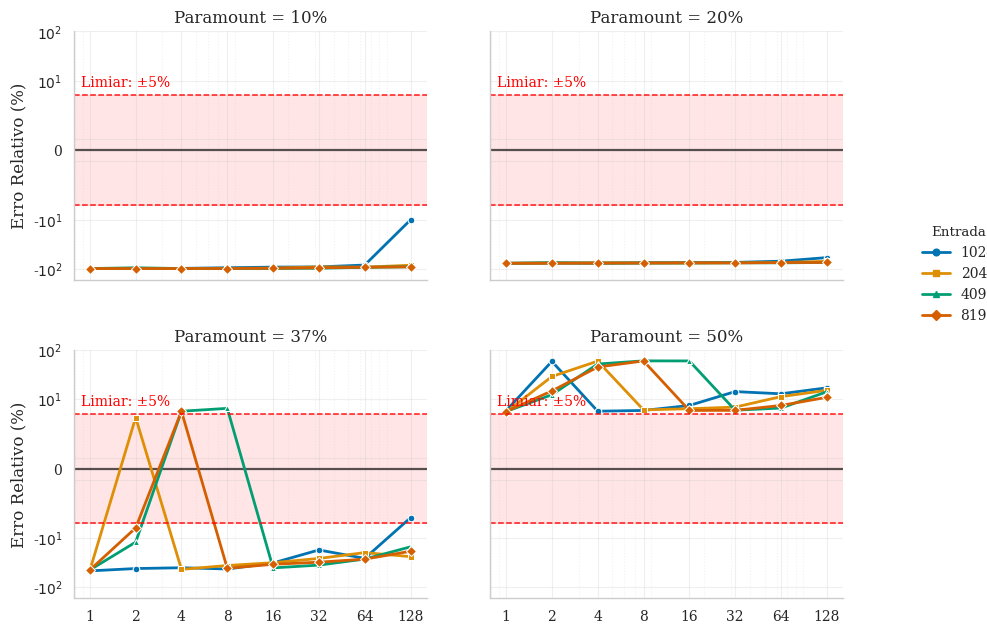

In [29]:
# Célula de execução: troque apenas o diretório da aplicação

# Exemplo 1 (seus dados atuais):
app_dir = os.path.join(os.getcwd(), "mandelbrot-afinidade")

# Exemplo 2 (quando cada aplicação estiver em uma pasta própria):
# app_dir = "/caminho/para/minha-aplicacao"

df_errors = generate_graphs(app_dir, limiar=5.0, vmax=100.0, save_prefix=None)

APP: /home/reilta/Documents/mestrado/mandelbrot
total.out: /home/reilta/Documents/mestrado/mandelbrot/out/total.out
total.json: /home/reilta/Documents/mestrado/mandelbrot/total.json
parciais: ['10.json', '20.json', '37.json', '50.json']
df_errors: 128 linhas | 4 porcentagens


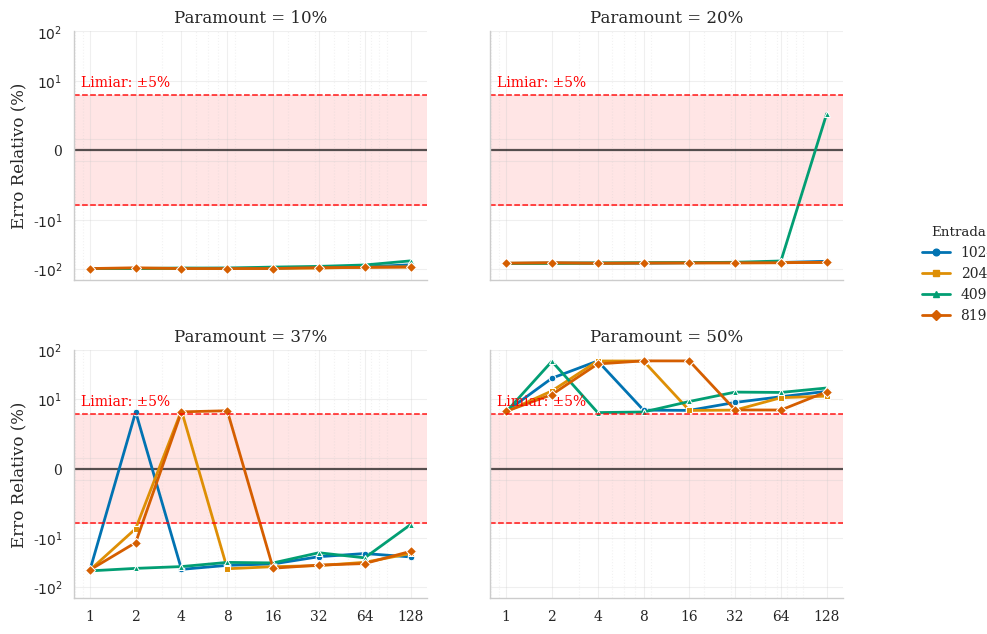

In [30]:
# Célula de execução: troque apenas o diretório da aplicação

# Exemplo 1 (seus dados atuais):
app_dir = os.path.join(os.getcwd(), "mandelbrot")

# Exemplo 2 (quando cada aplicação estiver em uma pasta própria):
# app_dir = "/caminho/para/minha-aplicacao"

df_errors = generate_graphs(app_dir, limiar=5.0, vmax=100.0, save_prefix=None)

APP: /home/reilta/Documents/mestrado/matrix-multiplication
total.out: /home/reilta/Documents/mestrado/matrix-multiplication/out/total.out
total.json: /home/reilta/Documents/mestrado/matrix-multiplication/total.json
parciais: ['10.json', '20.json', '37.json', '50.json']
df_errors: 160 linhas | 4 porcentagens


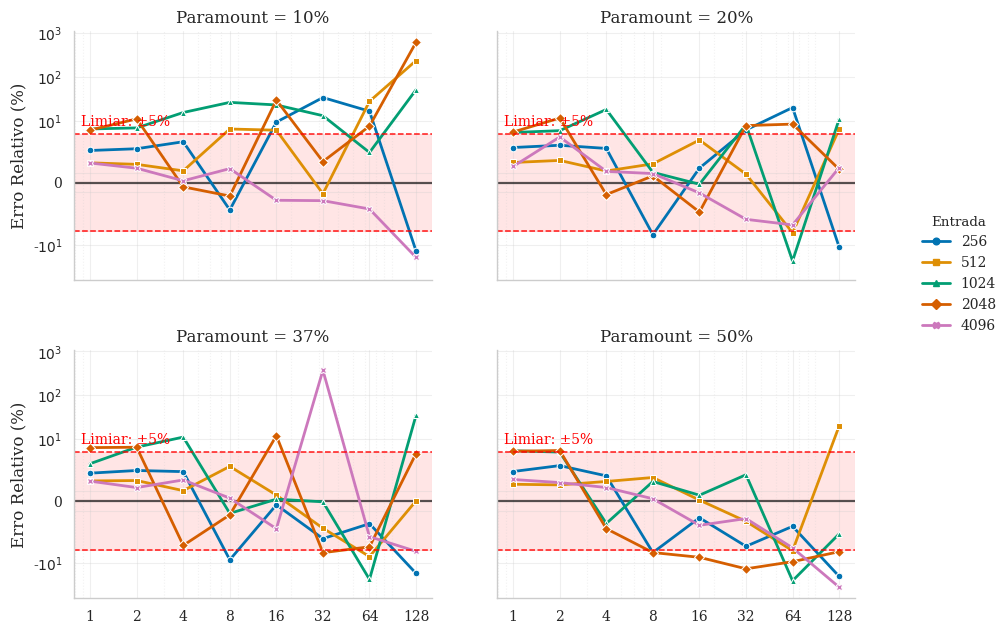

In [31]:
# Célula de execução: troque apenas o diretório da aplicação

# Exemplo 1 (seus dados atuais):
app_dir = os.path.join(os.getcwd(), "matrix-multiplication")

# Exemplo 2 (quando cada aplicação estiver em uma pasta própria):
# app_dir = "/caminho/para/minha-aplicacao"

df_errors = generate_graphs(app_dir, limiar=5.0, vmax=100.0, save_prefix=None)

APP: /home/reilta/Documents/mestrado/matrix-multiplication-afinidade
total.out: /home/reilta/Documents/mestrado/matrix-multiplication-afinidade/out/total.out
total.json: /home/reilta/Documents/mestrado/matrix-multiplication-afinidade/total.json
parciais: ['10.json', '20.json', '37.json', '50.json']
df_errors: 160 linhas | 4 porcentagens


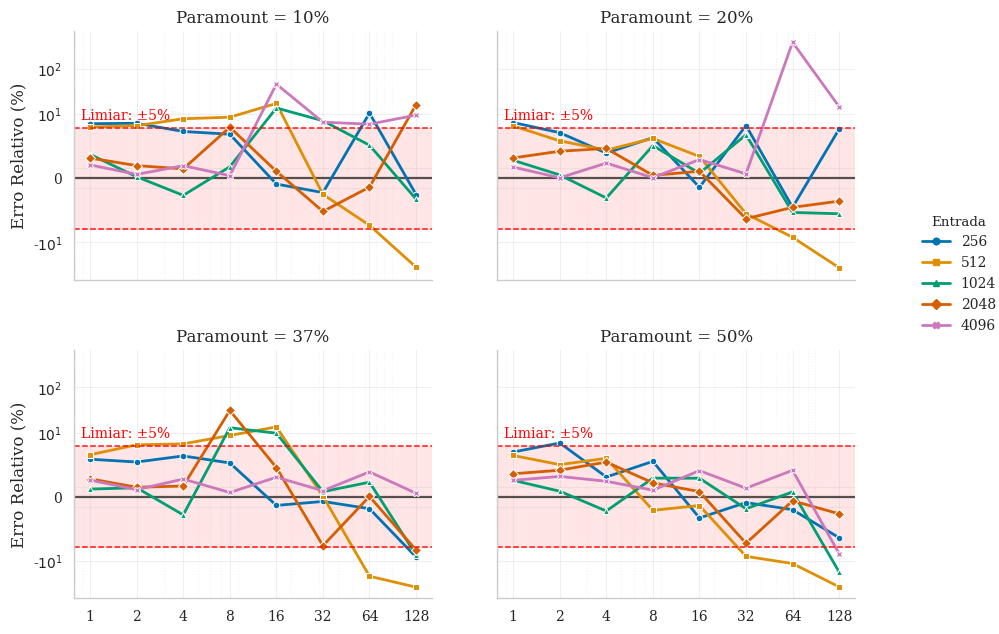

In [32]:
# Célula de execução: troque apenas o diretório da aplicação

# Exemplo 1 (seus dados atuais):
app_dir = os.path.join(os.getcwd(), "matrix-multiplication-afinidade")

# Exemplo 2 (quando cada aplicação estiver em uma pasta própria):
# app_dir = "/caminho/para/minha-aplicacao"

df_errors = generate_graphs(app_dir, limiar=5.0, vmax=100.0, save_prefix=None)